In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, average_precision_score
from tqdm import tqdm  # Import tqdm for the progress bar
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:


class BasicBlockWitOuthAttention(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockWitOuthAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
      #  self.attention = SelfAttention(out_channels)

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.functional.relu(out)
      #  out = self.attention(out)
        return out

class ASDataset(Dataset):
    def __init__(self, client_file: str, imposter_file: str, transforms=None):
        with open(client_file, "r") as f:
            client_files = f.read().splitlines()
        with open(imposter_file, "r") as f:
            imposter_files = f.read().splitlines()
        self.labels = torch.cat((torch.ones(len(client_files)), torch.zeros(len(imposter_files))))
        self.imgs = client_files + imposter_files
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img = Image.open(img_name)
        label = self.labels[idx]
        if self.transforms:
            img = self.transforms(img)
        return img, label


# Transformations for the input images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ResNet18 model with SelfAttention
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class BasicBlockWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.attention = SelfAttention(out_channels)

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        out = self.attention(out)
        return out

class ResNet18WithAttention(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18WithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = nn.Sequential(
            BasicBlockWitOuthAttention(64, 64),
            BasicBlockWitOuthAttention(64, 64)
        )
        self.attention1 = SelfAttention(64)
        self.layer2 = nn.Sequential(
            BasicBlockWitOuthAttention(64, 128, stride=2),
            BasicBlockWitOuthAttention(128, 128)
        )
        self.attention2 = SelfAttention(128)
        self.layer3 = nn.Sequential(
            BasicBlockWitOuthAttention(128, 256, stride=2),
            BasicBlockWitOuthAttention(256, 256)
        )
        self.attention3 = SelfAttention(256)
        self.layer4 = nn.Sequential(
            BasicBlockWitOuthAttention(256, 512, stride=2),
            BasicBlockWitOuthAttention(512, 512)
        )
        self.attention4 = SelfAttention(512)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.attention1(x)
        x = self.layer2(x)
        x = self.attention2(x)
        x = self.layer3(x)
        x = self.attention3(x)
        x = self.layer4(x)
        x = self.attention4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

ResNet18WithAttention()

ResNet18WithAttention(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlockWitOuthAttention(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlockWitOuthAttention(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): B

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic Block without Attention
class BasicBlockWithoutAttention(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockWithoutAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet18 without Attention
class ResNet18WithoutAttention(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18WithoutAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = nn.Sequential(
            BasicBlockWithoutAttention(64, 64),
            BasicBlockWithoutAttention(64, 64)
        )
        self.layer2 = nn.Sequential(
            BasicBlockWithoutAttention(64, 128, stride=2),
            BasicBlockWithoutAttention(128, 128)
        )
        self.layer3 = nn.Sequential(
            BasicBlockWithoutAttention(128, 256, stride=2),
            BasicBlockWithoutAttention(256, 256)
        )
        self.layer4 = nn.Sequential(
            BasicBlockWithoutAttention(256, 512, stride=2),
            BasicBlockWithoutAttention(512, 512)
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the model
model_without_attention = ResNet18WithoutAttention(num_classes=1)
print(model_without_attention)


ResNet18WithoutAttention(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlockWithoutAttention(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlockWithoutAttention(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2)

In [3]:
# Transformations for the input images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create instances of the datasets /kaggle/input/nuaaaa/raw/client_test_raw.txt
train_dataset = ASDataset(client_file="/kaggle/input/nuaaaa/raw/client_train_raw.txt", imposter_file="/kaggle/input/nuaaaa/raw/imposter_train_raw.txt", transforms=preprocess)
val_dataset = ASDataset(client_file="/kaggle/input/nuaaaa/raw/client_test_raw.txt", imposter_file="/kaggle/input/nuaaaa/raw/imposter_test_raw.txt", transforms=preprocess)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18WithAttention().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# num_epochs = 20

train_loss_history = []
train_accuracy_history = []

In [4]:
from tqdm import tqdm
from collections import OrderedDict

def get_accuracy(preds, labels):
    return torch.sum((preds.flatten() > 0.5) == labels.to(device)) / labels.numel()

def train(epoch):
    running_loss = 0.0 
    running_acc = 0.0
    model.train()
    for i, (inputs, labels) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader))):
        pbar.set_postfix(**msg)
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(
            outputs, labels.unsqueeze(-1).to(device)
        )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += get_accuracy(outputs, labels.to(device))
        if not i % 10 and i > 0:
            msg.update({"train_epoch": epoch + 1, "loss": running_loss / i, "acc": (running_acc / i).item()})
            pbar.set_postfix(**msg)


def validate():
    val_loss = 0.0  
    val_acc = 0.0
    model.eval()
    for i, (inputs, labels) in enumerate(val_loader):
        with torch.no_grad():
            outputs = model(inputs.to(device))
        loss = criterion(
            outputs, labels.unsqueeze(-1).to(device)  # Считаем loss
        )
        val_loss += loss.item()
        val_acc += get_accuracy(outputs, labels.to(device))
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    scheduler.step()
    msg.update({"val_loss": val_loss, "val_acc": val_acc.item()})
    print(f"val_loss: {val_loss}, val_acc: {val_acc.item()}")
    return val_acc.item()
    
msg = OrderedDict({"train_epoch": None, "loss": None, "acc": None, \
                "val_loss": None, "val_acc": None})

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.35)
device = "cuda"

In [7]:
max_val_acc = 0
num_epochs = 2
for epoch in range(num_epochs):
    optimizer.zero_grad()
    train(epoch)
    val_acc = validate()
    if val_acc > max_val_acc:
        max_val_acc = val_acc
        torch.save(model.state_dict(), f"as_model_{val_acc:.3f}.pt")

100%|██████████| 437/437 [02:55<00:00,  2.48it/s, acc=0.976, loss=0.0785, train_epoch=1, val_acc=None, val_loss=None]


val_loss: 1.2211031827872998, val_acc: 0.6944566369056702


100%|██████████| 437/437 [02:56<00:00,  2.48it/s, acc=0.992, loss=0.0372, train_epoch=2, val_acc=0.694, val_loss=1.22]


val_loss: 0.4621924160457158, val_acc: 0.8766798377037048


In [8]:
from sklearn.metrics import roc_auc_score

model.load_state_dict(torch.load("/kaggle/working/as_model_0.694.pt"))
model.eval()

ResNet18WithAttention(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlockWitOuthAttention(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlockWitOuthAttention(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): B

In [9]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, average_precision_score
from tqdm import tqdm  # Import tqdm for the progress bar
import seaborn as sns
import matplotlib.pyplot as plt

outputs = []
y_true = []
for i, (inputs, labels) in enumerate(val_loader):
    with torch.no_grad():
        outputs.append(model(inputs.to(device)).flatten().cpu().numpy())
        y_true.append(labels.numpy())
preds = (np.concatenate(outputs) > 0.5).astype(int)
outputs = np.concatenate(outputs)
y_true = np.concatenate(y_true)

APCER 0.3174796042353758
BPCER 0.28405710886377156
ACER 0.3007683565495737
FRR 0.28405710886377156
FAR 0.3174796042353758
HTER 0.3007683565495737
ROC AUC score: 0.7243885968967521
EER: 0.29925360180524213
F1 score: 0.633587786259542
Precision score: 0.5682247403210576
Recall score: 0.7159428911362284


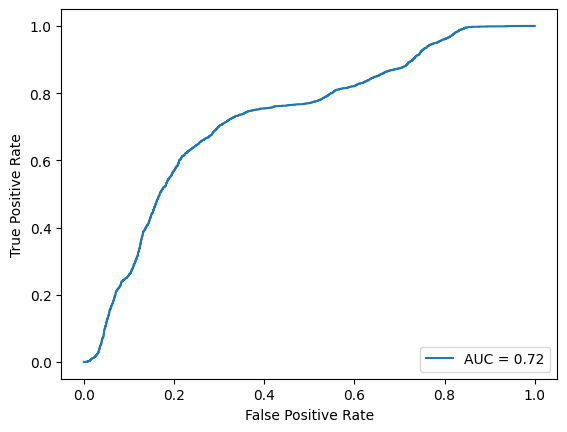

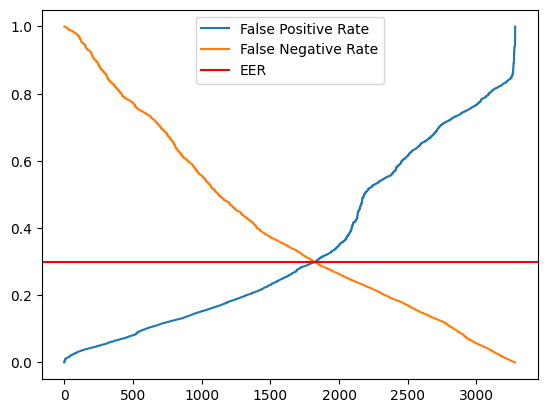

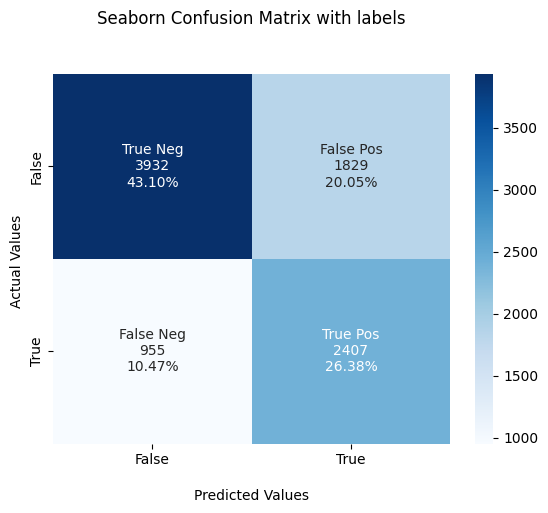

In [10]:
from sklearn.metrics import roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt


tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

apcer = fp/(tn + fp)
bpcer = fn/(fn + tp)
acer = (apcer + bpcer) / 2.0
frr = fn/(fn + tp)
far = fp/(fp + tn)
hter = (frr + far) / 2.0

print('APCER', apcer)
print('BPCER', bpcer)
print('ACER', acer)
print('FRR', frr)
print('FAR', far)
print('HTER', hter)

fpr, tpr, threshold = roc_curve(y_true, outputs, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("ROC AUC score:", roc_auc_score(y_true, outputs))
print("EER:", EER)
print("F1 score:", metrics.f1_score(y_true, preds))
print("Precision score:", metrics.precision_score(y_true, preds))
print("Recall score:", metrics.recall_score(y_true, preds))

fpr, tpr, thresholds = metrics.roc_curve(y_true, outputs)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,)
display.plot()
plt.show()
plt.plot(fpr, label="False Positive Rate")
fnr = 1 - tpr
plt.plot(fnr, label="False Negative Rate")
plt.axhline(y=EER, label="EER", color='r', linestyle='-')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns


cf_matrix = confusion_matrix(y_true, preds)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()